## Import required packages

In [1]:
%load_ext autoreload
%autoreload

In [2]:
from IPython.core.debugger import set_trace
from io import StringIO
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
import math
import missingno as msno
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.ensemble import IsolationForest
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()


## **Data Analysis**

In [3]:
trainDf = pd.read_csv('train.csv')
trainDf.replace("nan", np.nan, inplace=True)
trainDf.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [176]:
# we can drop the ID column
# trainDf.drop(columns=['Id'], axis=1, inplace=True)

In [356]:
def dataset_datatypes_counts(data, col_sample_size):
    '''
    Identifies the Numerical, Categorial, Text, and Temporal(DateTime) features of the input dataframe.
    Considers the 
    Prints the different datatype columns along with a random sample values from each feature for a quick eyeball check of data
    This method is for just getting an understanding of different datatypes variables we have in the dataset. 
    Be cautious about the year feature
    '''
    # Caterogies mentioned as numerical values need to be considered as categories
    buf = StringIO()
    data.info(buf=buf)
    print(f"""\n:: dataset(DataFrame) Info ::\n\n{buf.getvalue()}""")

    string_vars_list = []
    categorical_vars_list = []
    numerical_vars_list = []

    numerical_vars_w_random_sample_list = []
    categorical_vars_w_random_sample_list = []
        
    for i in list(data.select_dtypes(include=[np.number, np.float64, np.float32]).columns):
#         if len(data[i].unique()) <= 5:
#             categorical_vars_list.append(i)
#             categorical_vars_w_random_sample_list.append(f"{i} - {data[i].dropna().sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
#         else:
#             numerical_vars_list.append(i)
#             numerical_vars_w_random_sample_list.append(f"{i} - {data[i].sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
#             #print(f"{i} - {data[i].sample(n=col_sample_size, random_state=42).tolist()}")
        numerical_vars_list.append(i)
        numerical_vars_w_random_sample_list.append(f"{i} - {data[i].sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
        #print(f"{i} - {data[i].sample(n=col_sample_size, random_state=42).tolist()}")            
    
    
    for cat_name in list(data.select_dtypes(include=['category', 'object']).columns):
        if len(data[cat_name].unique()) > 50:
            string_vars_list.append(cat_name)
        else:
            categorical_vars_list.append(cat_name)
            categorical_vars_w_random_sample_list.append(f"{cat_name} - {data[cat_name].dropna().sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
            # print(f"{cat_name} - {data[cat_name].dropna().sample(n=col_sample_size, replace=True, random_state=42).tolist()}")

    temporal_vars_list = list(data.select_dtypes(include=['datetime', 'datetime64', 'timedelta', 'timedelta64', 'datetimetz']).columns)

    print(f"\n:: numerical_features :: {len(numerical_vars_w_random_sample_list)}\n\n{chr(10).join(sorted(numerical_vars_w_random_sample_list))}\n""")
    print(f"\n:: categorical_features :: {len(categorical_vars_w_random_sample_list)}\n\n{chr(10).join(sorted(categorical_vars_w_random_sample_list))}\n")
    print(f"\n:: string/text_features :: {len(string_vars_list)}\n{string_vars_list}\n")
    print(f"\n:: temporal/datetime_features :: {len(temporal_vars_list)}\n{chr(10).join(sorted(temporal_vars_list))}\n")

    print(f"Dateframe Rows : {data.shape[0]}, Columns : {data.shape[1]}")
    print(f"Numerical({len(numerical_vars_w_random_sample_list)}) + Categorical({len(categorical_vars_w_random_sample_list)}) + Text({len(string_vars_list)}) + Temporal({len(temporal_vars_list)}) = {len(numerical_vars_w_random_sample_list)+len(categorical_vars_w_random_sample_list)+len(string_vars_list)+len(temporal_vars_list)}")
    
    return numerical_vars_list, categorical_vars_list, string_vars_list, temporal_vars_list

num_feat, cat_feat, text_feat, datetime_feat = dataset_datatypes_counts(data=trainDf, col_sample_size=10)


:: dataset(DataFrame) Info ::

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 

As we are not going to create any new feature about the no. of houses sold between two time frames or years, we will consider the year feature as categorical. Below we change the datatype of year feature to object - YearBuilt, YearRemodAdd.
Similarly, Fireplaces, KitchenAbvGr, HalfBath, GarageCars, FullBath, BsmtHalfBath, BsmtFullBath need to be converted as numerical feature

In [357]:
def datatype_conversion(data, feat_list, conversion_type):
    if conversion_type == 'cat_to_num':
        for feat in feat_list:
            data[feat] = data[feat].astype('int',copy=False)
    
    if conversion_type == 'num_to_cat':
        for feat in feat_list:
            data[feat] = data[feat].astype('object',copy=False)
            
    return data

num_to_cat = ['MSSubClass', 'MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
trainDf = datatype_conversion(data=trainDf, feat_list=num_to_cat, conversion_type='num_to_cat')
num_feat, cat_feat, text_feat, datetime_feat = dataset_datatypes_counts(data=trainDf, col_sample_size=10)


:: dataset(DataFrame) Info ::

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 

In [358]:
# Alley: Type of alley access to property
#        Grvl	Gravel
#        Pave	Paved
#        NA 	No alley access

# Fill in NA with NoAlley in the Alley feature of the dataframe
trainDf['Alley'].fillna(value='NoAlley', inplace=True)

# Fence: Fence quality
#        GdPrv	Good Privacy
#        MnPrv	Minimum Privacy
#        GdWo	Good Wood
#        MnWw	Minimum Wood/Wire
#        NA	No Fence

# Fill in NA with NoFence in the Fence feature of the dataframe
trainDf['Fence'].fillna(value='NoFence', inplace=True)


# FireplaceQu: Fireplace quality
#        Ex	Excellent - Exceptional Masonry Fireplace
#        Gd	Good - Masonry Fireplace in main level
#        TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
#        Fa	Fair - Prefabricated Fireplace in basement
#        Po	Poor - Ben Franklin Stove
#        NA	No Fireplace

# Fill in NA with NoFireplace in the FireplaceQu feature of the dataframe
trainDf['FireplaceQu'].fillna(value='NoFireplace', inplace=True)

# GarageCond: Garage condition
#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
#        NA	No Garage

# Fill in NA with NoGarage in the GarageQual feature of the dataframe
trainDf['GarageCond'].fillna(value='NoGarage', inplace=True)

# GarageType: Garage location
#        2Types	More than one type of garage
#        Attchd	Attached to home
#        Basment	Basement Garage
#        BuiltIn	Built-In (Garage part of house - typically has room above garage)
#        CarPort	Car Port
#        Detchd	Detached from home
#        NA	No Garage

# Fill in NA with NoGarage in the GarageType feature of the dataframe
trainDf['GarageType'].fillna(value='NoGarage', inplace=True)

# GarageFinish: Interior finish of the garage
#        Fin	Finished
#        RFn	Rough Finished	
#        Unf	Unfinished
#        NA	No Garage

# Fill in NA with NoGarage in the GarageFinish feature of the dataframe
trainDf['GarageFinish'].fillna(value='NoGarage', inplace=True)

# GarageQual: Garage quality
#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
#        NA	No Garage

# Fill in NA with NoGarage in the GarageQual feature of the dataframe
trainDf['GarageQual'].fillna(value='NoGarage', inplace=True)


# BsmtExposure: Refers to walkout or garden level walls
#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement

# Fill in NA with NoBsmt in the BsmtExposure feature of the dataframe
trainDf['BsmtExposure'].fillna(value='NoBsmt', inplace=True)

# BsmtQual: Evaluates the height of the basement
#        Ex	Excellent (100+ inches)	
#        Gd	Good (90-99 inches)
#        TA	Typical (80-89 inches)
#        Fa	Fair (70-79 inches)
#        Po	Poor (<70 inches
#        NA	No Basement

# Fill in NA with NoBsmt in the BsmtQual feature of the dataframe
trainDf['BsmtQual'].fillna(value='NoBsmt', inplace=True)

# BsmtCond: Evaluates the general condition of the basement
#        Ex	Excellent
#        Gd	Good
#        TA	Typical - slight dampness allowed
#        Fa	Fair - dampness or some cracking or settling
#        Po	Poor - Severe cracking, settling, or wetness
#        NA	No Basement

# Fill in NA with NoBsmt in the BsmtCond feature of the dataframe
trainDf['BsmtCond'].fillna(value='NoBsmt', inplace=True)


# BsmtFinType1: Rating of basement finished area
#        GLQ	Good Living Quarters
#        ALQ	Average Living Quarters
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        LwQ	Low Quality
#        Unf	Unfinshed
#        NA	No Basement

# Fill in NA with NoBsmt in the BsmtFinType1 feature of the dataframe
trainDf['BsmtFinType1'].fillna(value='NoBsmt', inplace=True)


# PoolQC: Pool quality
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        NA	No Pool

# Fill in NA with NoPool in the PoolQC feature of the dataframe
trainDf['PoolQC'].fillna(value='NoPool', inplace=True)

# MiscFeature: Miscellaneous feature not covered in other categories
#        Elev	Elevator
#        Gar2	2nd Garage (if not described in garage section)
#        Othr	Other
#        Shed	Shed (over 100 SF)
#        TenC	Tennis Court
#        NA	None

# Fill in NA with None in the MiscFeature feature of the dataframe
trainDf['MiscFeature'].fillna(value='None', inplace=True)


# BsmtFinType2: Rating of basement finished area (if multiple types)
#        GLQ	Good Living Quarters
#        ALQ	Average Living Quarters
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        LwQ	Low Quality
#        Unf	Unfinshed
#        NA	No Basement

# Fill in NoBsmt with None in the BsmtFinType2 feature of the dataframe
trainDf['BsmtFinType2'].fillna(value='NoBsmt', inplace=True)


trainDf.info()
display(trainDf.isnull().sum().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

LotFrontage      259
GarageYrBlt       81
MasVnrType         8
MasVnrArea         8
Electrical         1
SalePrice          0
ExterCond          0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
ExterQual          0
BsmtQual           0
Foundation         0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
YearRemodAdd       0
YearBuilt          0
TotalBsmtSF        0
Utilities          0
MSSubClass         0
MSZoning           0
LotArea            0
Street             0
Alley              0
LotShape           0
LandContour        0
LotConfig          0
OverallCond        0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
BsmtUnfSF          0
HeatingQC          0
Heating            0
ScreenPorch        0
GarageQual         0
GarageCond         0
PavedDrive         0
WoodDeckSF   

In [359]:
trainDf['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [360]:
# List the features having missing values
feat_w_missing_values_list = trainDf.columns[trainDf.isna().any()].tolist()

print(f"Features with missing values : {len(feat_w_missing_values_list)}\n\n{feat_w_missing_values_list}")

# percentage of missing values
total = trainDf.isnull().sum().sort_values(ascending=False)
percent = (trainDf.isnull().sum()/trainDf.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

Features with missing values : 5

['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical', 'GarageYrBlt']


,Total,Percent
LotFrontage,259,0.177
GarageYrBlt,81,0.055
MasVnrType,8,0.005
MasVnrArea,8,0.005
Electrical,1,0.001
SalePrice,0,0.000
ExterCond,0,0.000
RoofStyle,0,0.000
RoofMatl,0,0.000
Exterior1st,0,0.000


Text(0.5, 1.0, 'Percent missing data by feature')

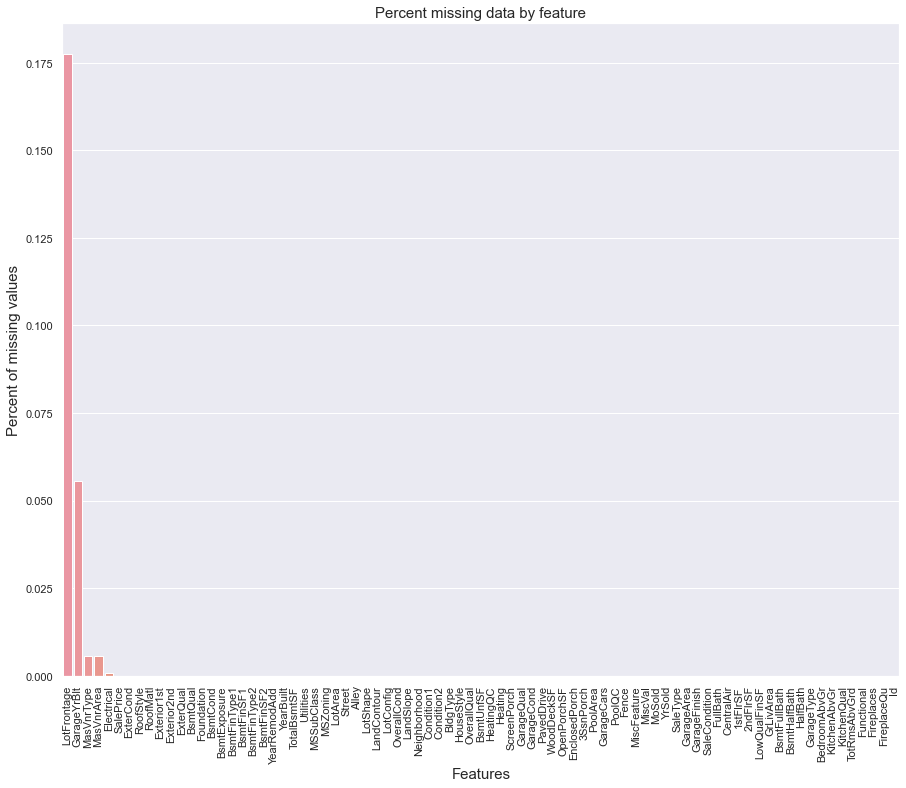

In [361]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

#### **Correlation Matrix**

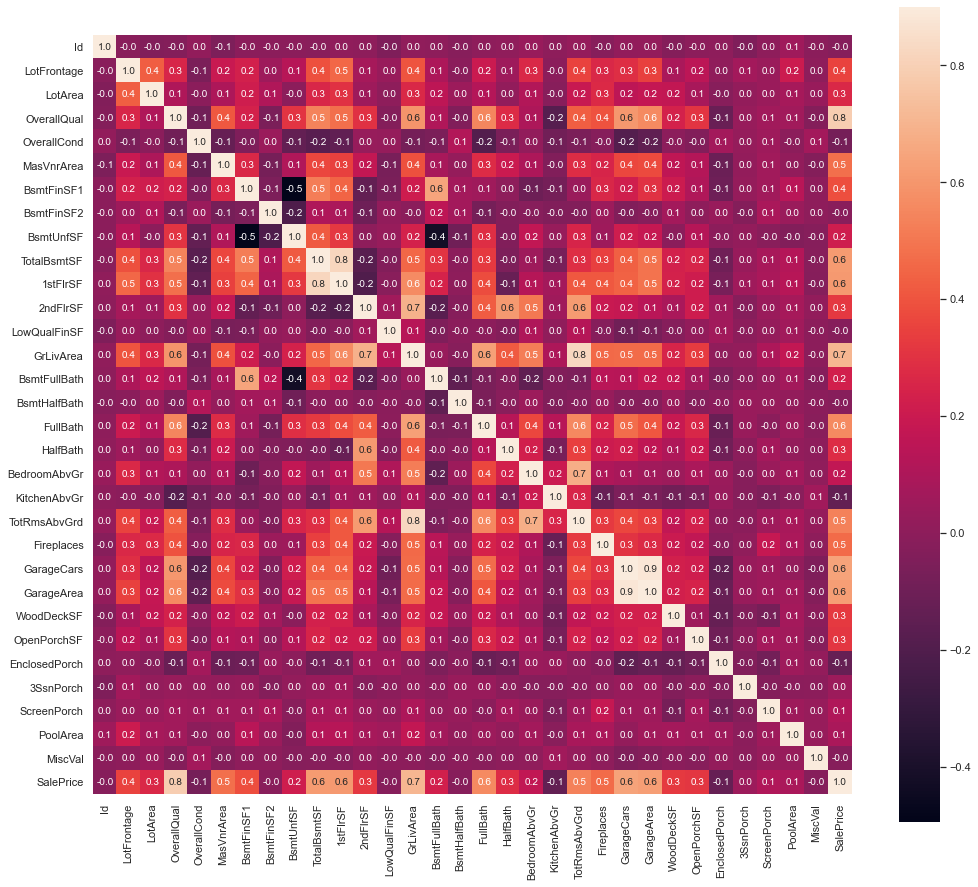

In [362]:
#correlation matrix
corrmat = trainDf.corr()
f, ax = plt.subplots(figsize=(17, 15))
#sns.set(font_scale=1.3)
sns.heatmap(corrmat, vmax=.9, annot=True, square=True, fmt='.1f', annot_kws={'size': 10});

### **Saleprice Correlation Matrix**

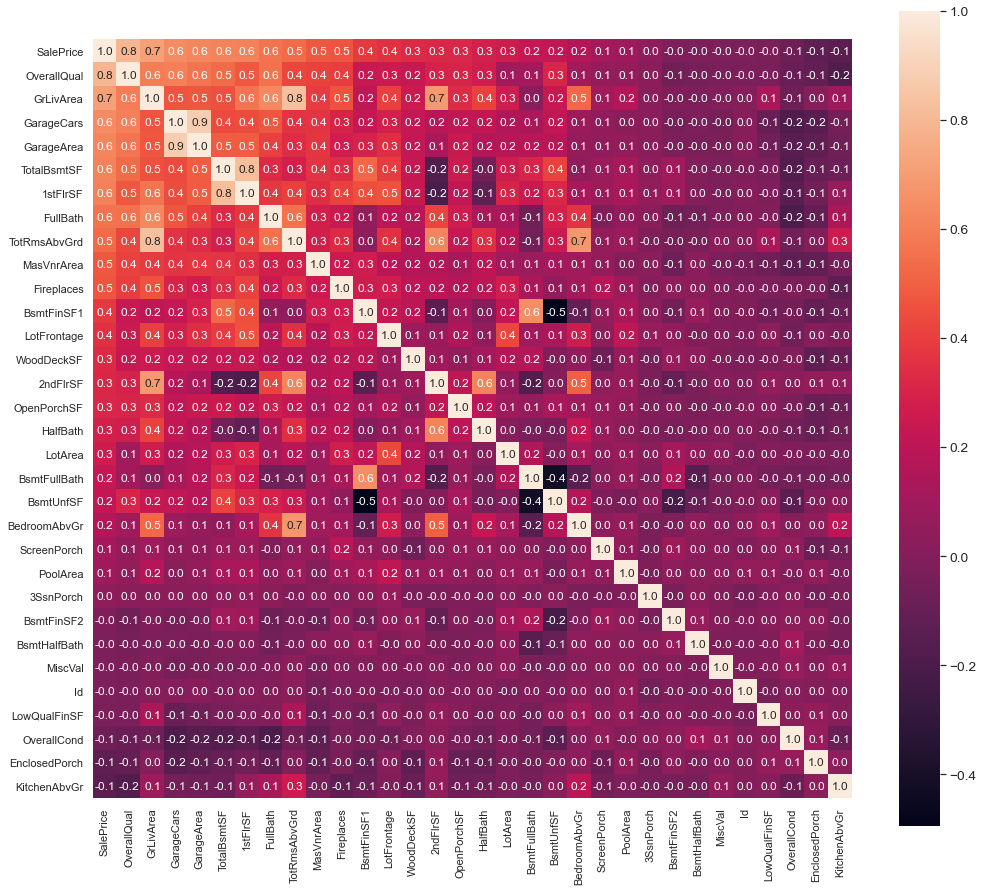

In [363]:
#saleprice correlation matrix
k = 50 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice', keep='all')['SalePrice'].index
#cm = np.corrcoef(trainDf[cols].values.T)
#cm = np.corrcoef(trainDf[cols].values)
df = trainDf[cols]
corrmat = df.corr()
f, ax = plt.subplots(figsize=(17, 15))
# sns.heatmap(corrmat, vmax=.8, square=True);
sns.set(font_scale=1.25)
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.1f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [364]:
s = corrmat['SalePrice'].sort_values(ascending=False)
s

SalePrice        1.000
OverallQual      0.791
GrLivArea        0.709
GarageCars       0.640
GarageArea       0.623
TotalBsmtSF      0.614
1stFlrSF         0.606
FullBath         0.561
TotRmsAbvGrd     0.534
MasVnrArea       0.477
Fireplaces       0.467
BsmtFinSF1       0.386
LotFrontage      0.352
WoodDeckSF       0.324
2ndFlrSF         0.319
OpenPorchSF      0.316
HalfBath         0.284
LotArea          0.264
BsmtFullBath     0.227
BsmtUnfSF        0.214
BedroomAbvGr     0.168
ScreenPorch      0.111
PoolArea         0.092
3SsnPorch        0.045
BsmtFinSF2      -0.011
BsmtHalfBath    -0.017
MiscVal         -0.021
Id              -0.022
LowQualFinSF    -0.026
OverallCond     -0.078
EnclosedPorch   -0.129
KitchenAbvGr    -0.136
Name: SalePrice, dtype: float64

### Outliers check/drop in the highly correlated features
We consider the features which are highly correlated as the features with correlation value >= 0.5

In [365]:
highly_corr_feat = s[abs(s)>=0.5].index.tolist()
print(f"""Highly Correlated Features : {len(highly_corr_feat)}\n{highly_corr_feat}""")

not_highly_correlated_feats = s[~s.index.isin(highly_corr_feat)].index.tolist()
print(f"""\nNot Highly Correlated Features : {len(not_highly_correlated_feats)}\n{not_highly_correlated_feats} """)


Highly Correlated Features : 9
['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd']

Not Highly Correlated Features : 23
['MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'ScreenPorch', 'PoolArea', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'Id', 'LowQualFinSF', 'OverallCond', 'EnclosedPorch', 'KitchenAbvGr'] 


### Drop the features which are less correlated to the target SalePrice

In [366]:
trainDf = trainDf.drop(columns=not_highly_correlated_feats, axis=1).reset_index(drop=True)

In [367]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   object
 1   MSZoning       1460 non-null   object
 2   Street         1460 non-null   object
 3   Alley          1460 non-null   object
 4   LotShape       1460 non-null   object
 5   LandContour    1460 non-null   object
 6   Utilities      1460 non-null   object
 7   LotConfig      1460 non-null   object
 8   LandSlope      1460 non-null   object
 9   Neighborhood   1460 non-null   object
 10  Condition1     1460 non-null   object
 11  Condition2     1460 non-null   object
 12  BldgType       1460 non-null   object
 13  HouseStyle     1460 non-null   object
 14  OverallQual    1460 non-null   int64 
 15  YearBuilt      1460 non-null   object
 16  YearRemodAdd   1460 non-null   object
 17  RoofStyle      1460 non-null   object
 18  RoofMatl       1460 non-null

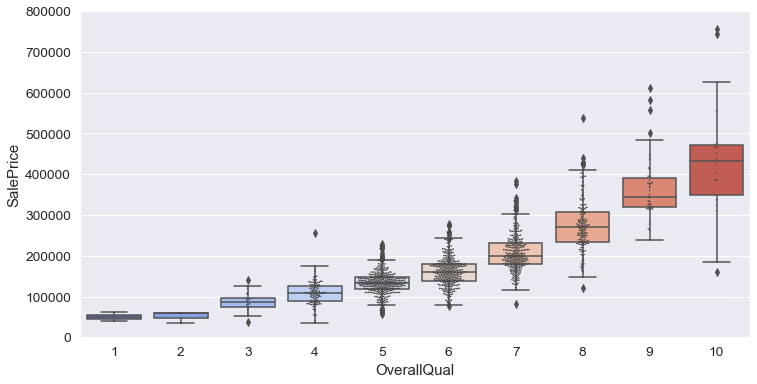

In [368]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([trainDf['SalePrice'], trainDf[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data, palette="coolwarm")
fig = sns.swarmplot(x=var, y="SalePrice", data=data, color=".25", size=1.5)
fig.axis(ymin=0, ymax=800000);

In [369]:
# dropping outliers in the OverallQual feature
outliers_OverallQual_4 = trainDf.loc[(trainDf['OverallQual']==4) & (trainDf['SalePrice']>200000.0)]
outliers_OverallQual_8 = trainDf.loc[(trainDf['OverallQual']==8) & (trainDf['SalePrice']>500000.0)]
outliers_OverallQual_9 = trainDf.loc[(trainDf['OverallQual']==9) & (trainDf['SalePrice']>500000.0)]
outliers_OverallQual_10 = trainDf.loc[(trainDf['OverallQual']==10) & (trainDf['SalePrice']>700000.0)]
outliers_OverallQual = pd.concat([outliers_OverallQual_4, outliers_OverallQual_8, 
                                  outliers_OverallQual_9, outliers_OverallQual_10])
display(outliers_OverallQual[highly_corr_feat])
trainDf = trainDf.drop(outliers_OverallQual.index).reset_index(drop=True)

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd
457,256000,4,1663,2,529,1364,1663,1,6
769,538000,8,3279,3,841,1650,1690,3,12
178,501837,9,2234,3,1166,2216,2234,2,9
803,582933,9,2822,3,1020,1734,1734,3,12
898,611657,9,2364,3,820,2330,2364,2,11
1046,556581,9,2868,3,716,1992,1992,3,11
691,755000,10,4316,3,832,2444,2444,3,10
1182,745000,10,4476,3,813,2396,2411,3,10


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

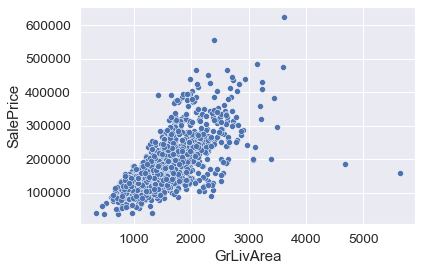

In [370]:
#box plot overallqual/saleprice
# var = 'GrLivArea'
# data = pd.concat([trainDf['SalePrice'], trainDf[var]], axis=1)
# f, ax = plt.subplots(figsize=(12, 6))
# fig = sns.boxplot(x=var, y="SalePrice", data=data, palette="coolwarm")
# fig = sns.swarmplot(x=var, y="SalePrice", data=data, color=".25", size=1.5)
# fig.axis(ymin=0, ymax=800000);

sns.scatterplot(data=trainDf, x="GrLivArea", y="SalePrice")

In [371]:
# dropping outliers in the GrLivArea feature which are above 4000 GrLivArea on x-axis

outliers_GrLivArea = trainDf.loc[(trainDf['GrLivArea']>4000)]

display(outliers_GrLivArea[highly_corr_feat])
trainDf = trainDf.drop(outliers_GrLivArea.index).reset_index(drop=True)

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd
521,184750,10,4676,3,884,3138,3138,3,11
1290,160000,10,5642,2,1418,6110,4692,2,12


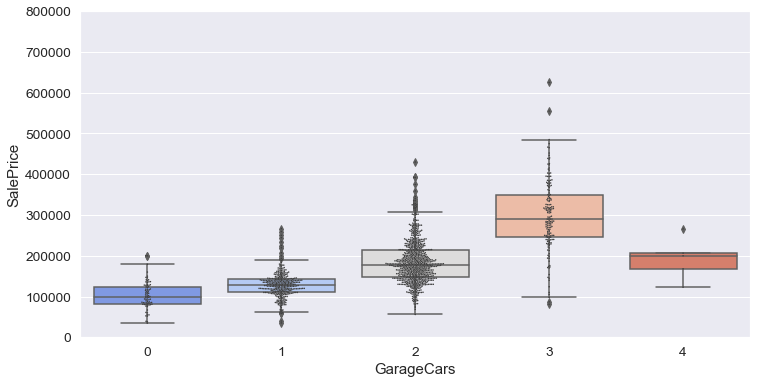

In [372]:
#box plot GarageCars/saleprice
var = 'GarageCars'
data = pd.concat([trainDf['SalePrice'], trainDf[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data, palette="coolwarm")
fig = sns.swarmplot(x=var, y="SalePrice", data=data, color=".25", size=1.5)
fig.axis(ymin=0, ymax=800000);

In [373]:
# dropping outliers in the GarageCars feature
outliers_GarageCars_3 = trainDf.loc[(trainDf['GarageCars']==3) & (trainDf['SalePrice']>500000.0)]
outliers_GarageCars_2 = trainDf.loc[(trainDf['GarageCars']==2) & (trainDf['SalePrice']>400000.0)]

outliers_GarageCars = pd.concat([outliers_GarageCars_3, outliers_GarageCars_2])
display(outliers_GarageCars[highly_corr_feat])
trainDf = trainDf.drop(outliers_GarageCars.index).reset_index(drop=True)
trainDf.info()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd
439,555000,10,2402,3,672,3094,2402,2,10
1161,625000,10,3627,3,807,1930,1831,3,10
494,430000,8,3228,2,546,3200,3228,3,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1447 non-null   object
 1   MSZoning       1447 non-null   object
 2   Street         1447 non-null   object
 3   Alley          1447 non-null   object
 4   LotShape       1447 non-null   object
 5   LandContour    1447 non-null   object
 6   Utilities      1447 non-null   object
 7   LotConfig      1447 non-null   object
 8   LandSlope      1447 non-null   object
 9   Neighborhood   1447 non-null   object
 10  Condition1     1447 non-null   object
 11  Condition2     1447 non-null   object
 12  BldgType       1447 non-null   object
 13  HouseStyle     1447 non-null   object
 14  OverallQual    1447 non-null   int64 
 15  YearBuilt      1447 non-null   object
 16  YearRemodAdd   1447 non-null   object
 17  RoofStyle      1447 non-null   object
 18  RoofMatl       1447 non-null

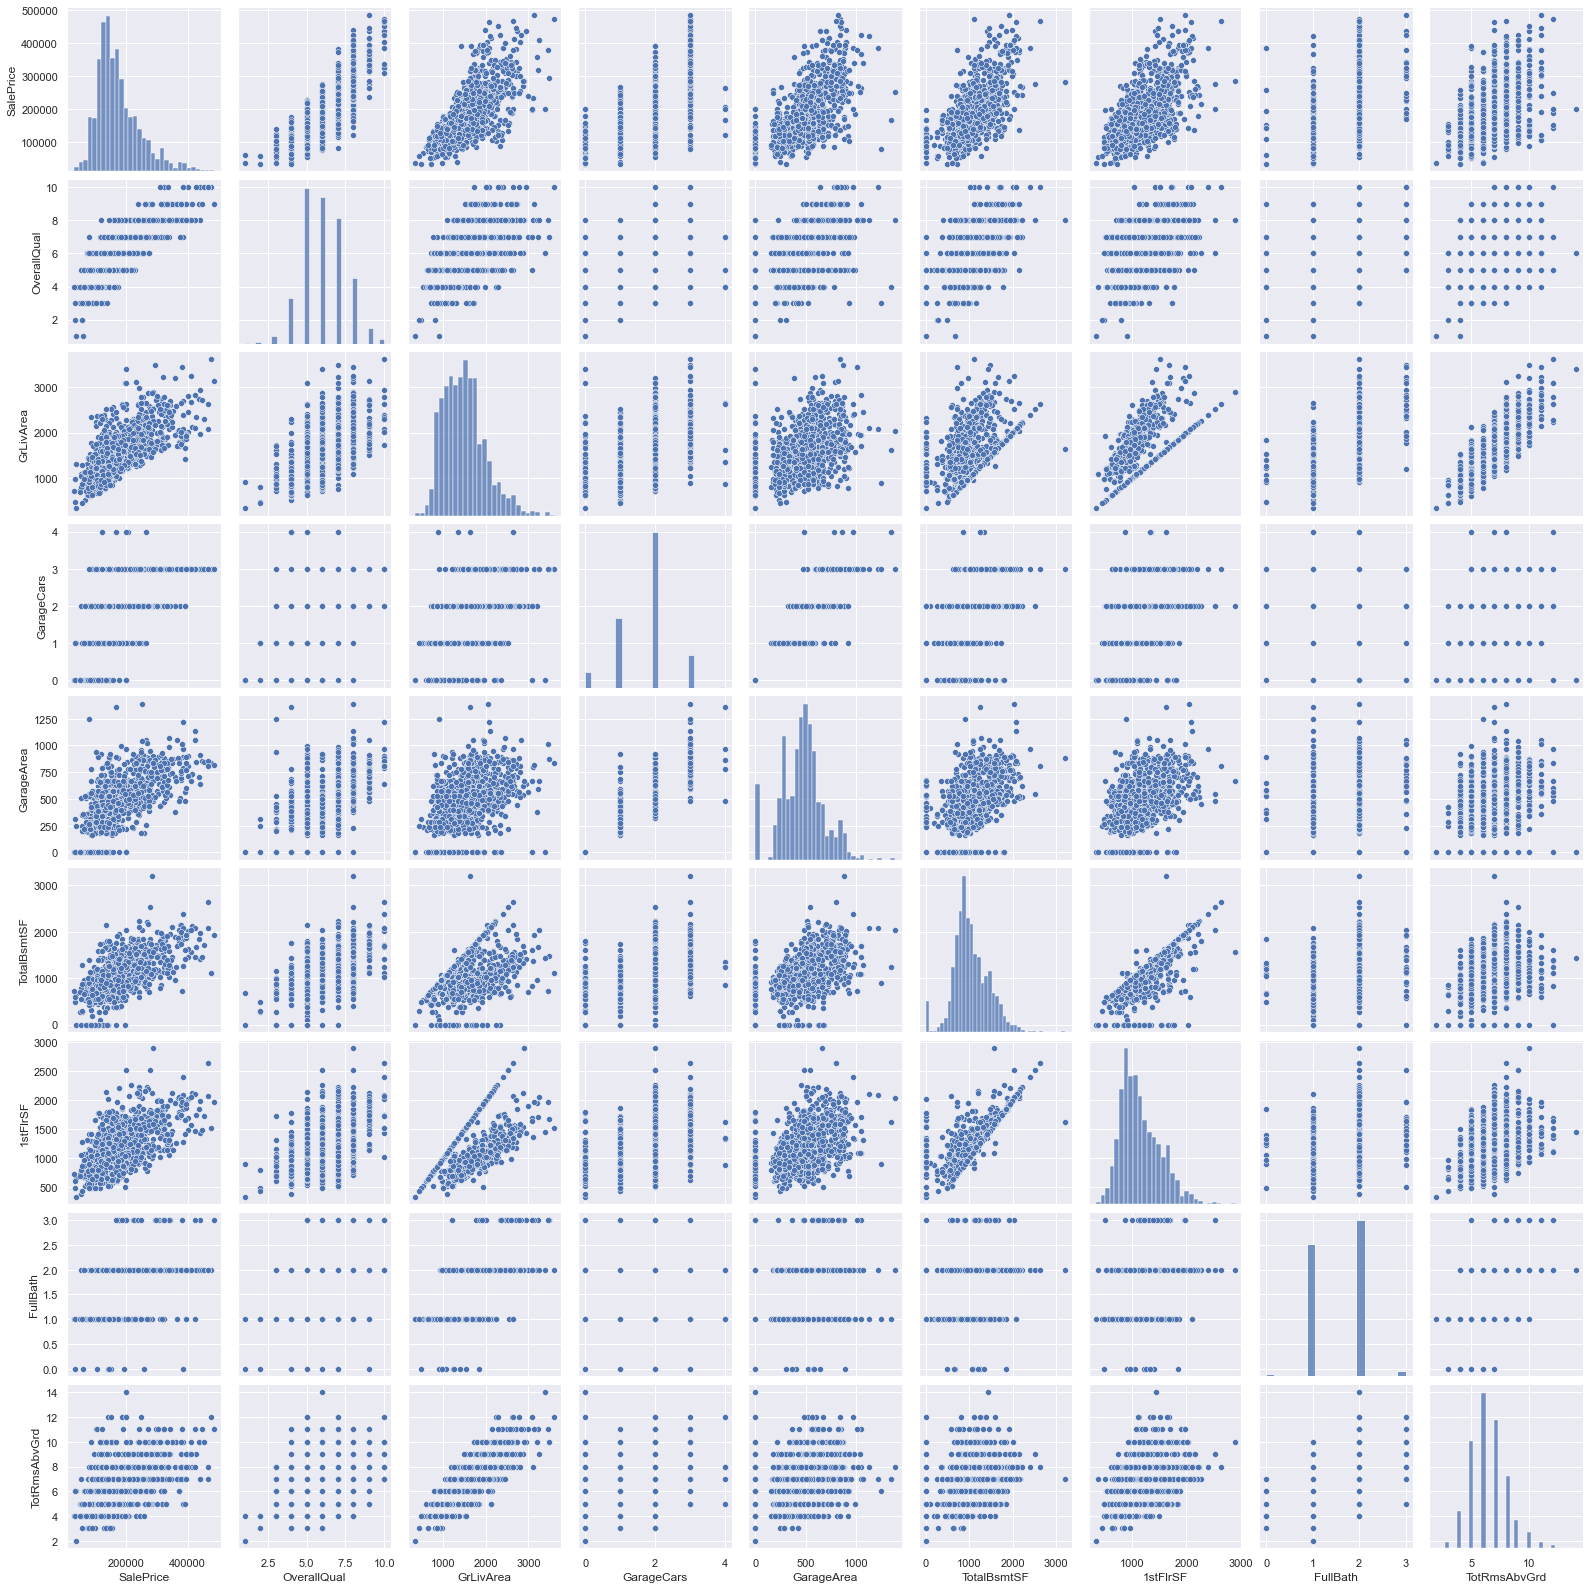

In [17]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd']
sns.pairplot(trainDf[cols], height = 2.5)
plt.show();

D:\SoftwareInstallation\Anaconda\envs\VirtualEnv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\SoftwareInstallation\Anaconda\envs\VirtualEnv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\SoftwareInstallation\Anaconda\envs\VirtualEnv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

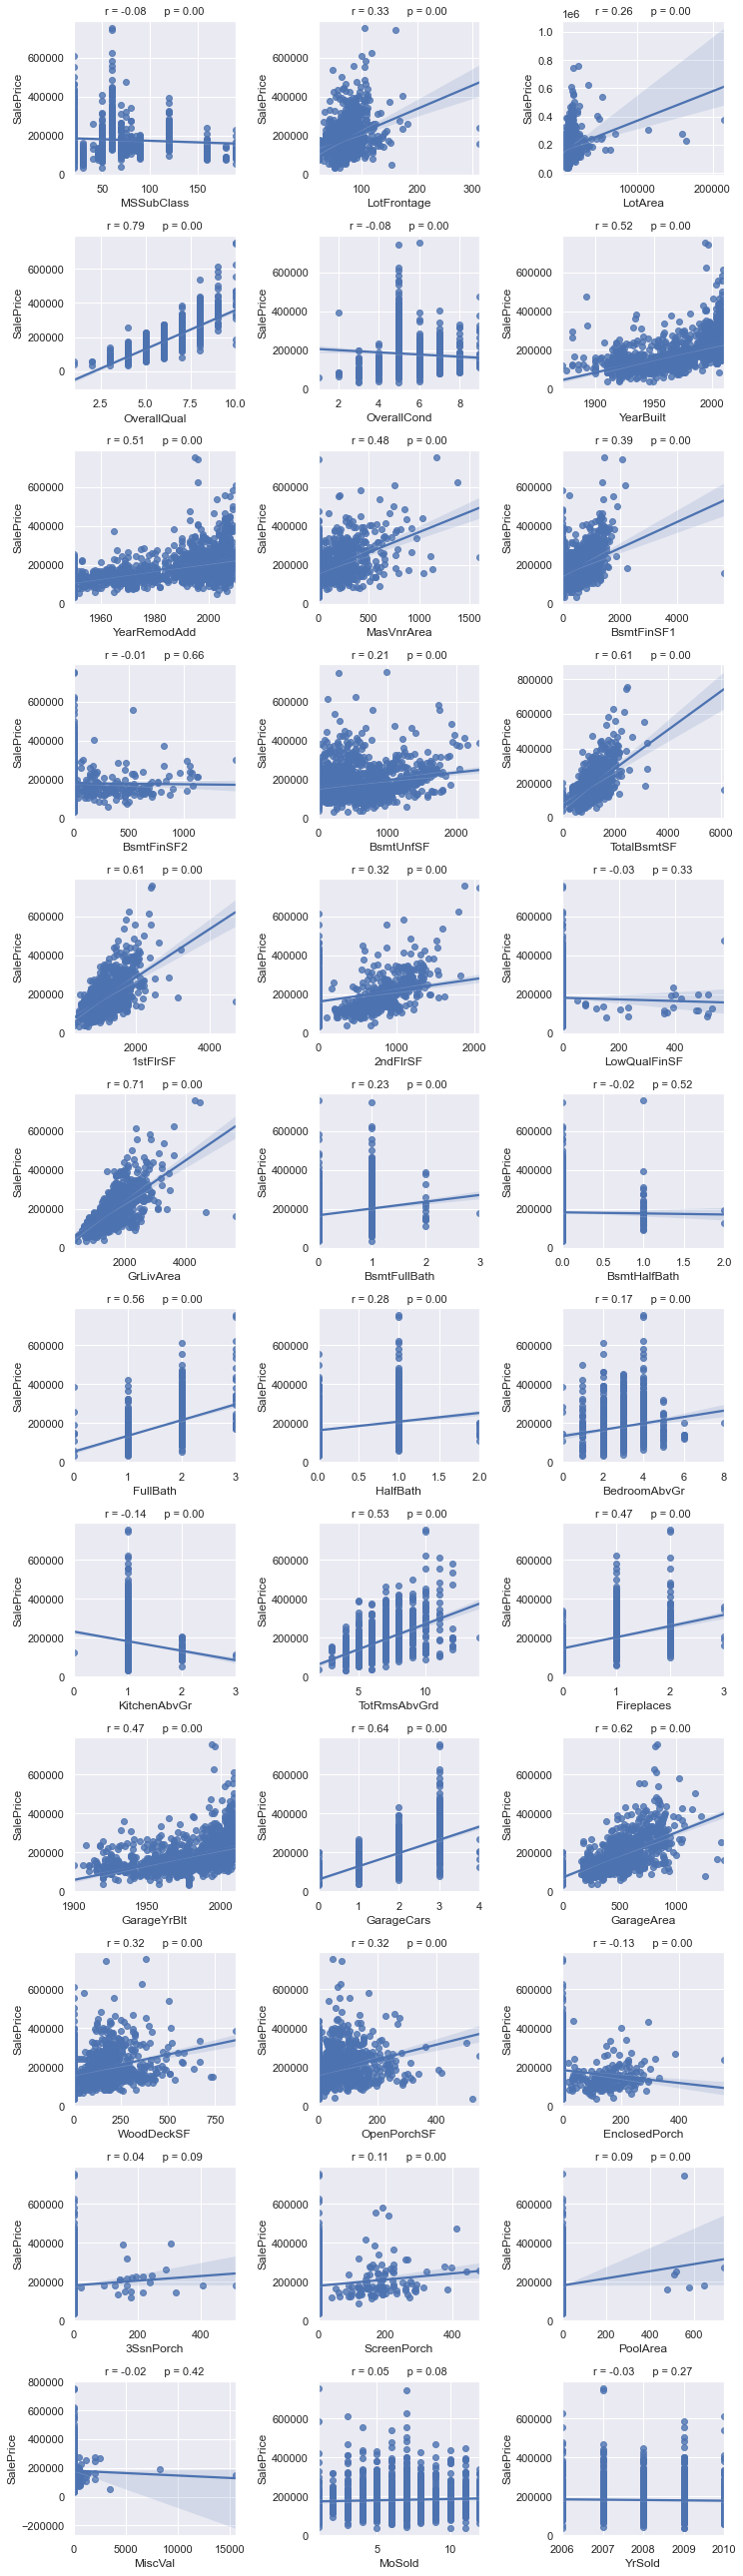

In [123]:
df_train = trainDf.copy()
df_train.fillna(df_train.mean(), inplace=True)
#df_test.fillna(df_test.mean(), inplace=True)
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
target = 'SalePrice'

nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]

for r in range(0, nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show() 

In [374]:
trainDf.describe()

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
count,1447.000,1447.000,1447.000,1447.000,1447.000,1447.000,1447.000,1447.000,1447.000
mean,6.074,1043.710,1151.079,1498.950,1.556,6.484,1.758,469.583,178053.343
std,1.355,401.175,360.491,486.876,0.542,1.586,0.744,210.573,71654.182
min,1.000,0.000,334.000,334.000,0.000,2.000,0.000,0.000,34900.000
25%,5.000,794.000,881.000,1127.000,1.000,5.000,1.000,326.500,129900.000
50%,6.000,990.000,1082.000,1456.000,2.000,6.000,2.000,478.000,162000.000
75%,7.000,1279.500,1379.500,1768.000,2.000,7.000,2.000,576.000,213000.000
max,10.000,3206.000,2898.000,3608.000,3.000,14.000,4.000,1390.000,485000.000


Alley  
NoAlley    1356
Grvl         50
Pave         41
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Alley   1447 non-null   object
dtypes: object(1)
memory usage: 11.4+ KB


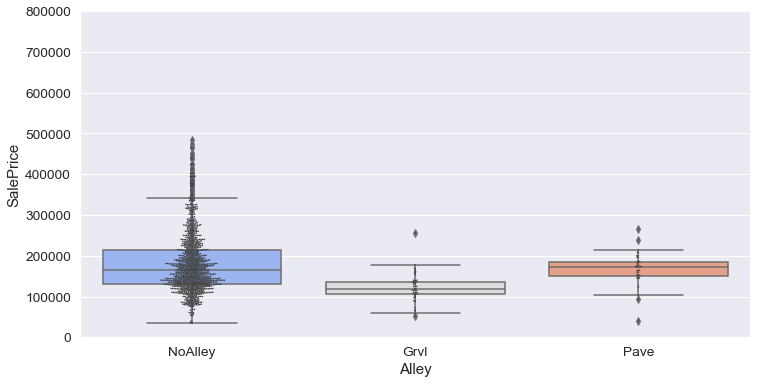

In [375]:
#box plot MoSold/saleprice
var = 'Alley'
data = pd.concat([trainDf['SalePrice'], trainDf[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data, palette="coolwarm")
fig = sns.swarmplot(x=var, y="SalePrice", data=data, color=".25", size=1.5)
fig.axis(ymin=0, ymax=800000);

display(trainDf[[var]].value_counts())
trainDf[[var]].info()

In [376]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

lm = ols('SalePrice~Alley', data=trainDf).fit()
dir(lm)
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
Alley,2.000,167586553134.248,83793276567.124,16.674,0.000
Residual,1444.000,7256642739960.047,5025375858.698,nan,nan


In [294]:
trainDf[trainDf['OverallQual'] == 10]['OverallQual']

clf = IsolationForest(n_estimators=100, contamination=0.5, max_samples='auto', random_state=42)
clf.fit(np.array(trainDf[trainDf['OverallQual'] == 10]['OverallQual']).reshape(-1, 1))
df['OverallQual'] = trainDf[['OverallQual']]
df['scores']=clf.decision_function(trainDf[['OverallQual']])
df['anomaly']=clf.predict(trainDf[['OverallQual']])
df


<ipython-input-294-248b3a0ae8aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OverallQual'] = trainDf[['OverallQual']]
<ipython-input-294-248b3a0ae8aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scores']=clf.decision_function(trainDf[['OverallQual']])
<ipython-input-294-248b3a0ae8aa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,Fireplaces,MasVnrArea,BsmtFinSF1,LotFrontage,OpenPorchSF,WoodDeckSF,2ndFlrSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,scores,anomaly
0,208500,7,1710,2,548,856,856,2,8,0,196.000,706,65.000,61,0,854,1,8450,1,150,0.000,1
1,181500,6,1262,2,460,1262,1262,2,6,1,0.000,978,80.000,0,298,0,0,9600,0,284,0.000,1
2,223500,7,1786,2,608,920,920,2,6,1,162.000,486,68.000,42,0,866,1,11250,1,434,0.000,1
3,140000,7,1717,3,642,756,961,1,7,1,0.000,216,60.000,35,0,756,0,9550,1,540,0.000,1
4,250000,8,2198,3,836,1145,1145,2,9,1,350.000,655,84.000,84,192,1053,1,14260,1,490,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1442,175000,6,1647,2,460,953,953,2,7,1,0.000,0,62.000,40,0,694,1,7917,0,953,0.000,1
1443,210000,6,2073,2,500,1542,2073,2,7,2,119.000,790,85.000,0,349,0,0,13175,1,589,0.000,1
1444,266500,7,2340,1,252,1152,1188,2,9,2,0.000,275,66.000,60,0,1152,0,9042,0,877,0.000,1
1445,142125,5,1078,1,240,1078,1078,1,5,0,0.000,49,68.000,0,366,0,0,9717,1,0,0.000,1


In [377]:
cat_feat = trainDf.select_dtypes(include=['category', 'object']).columns
cat_feat

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [378]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

target_feat = 'SalePrice'
cat_features = cat_feat

def anova_test(df, target_feat, cat_features):    
    aov_df = pd.DataFrame({'df': pd.Series([], dtype='float'),
                   'sum_sq': pd.Series([], dtype='float'),
                   'mean_sq': pd.Series([], dtype='float'),
                   'F': pd.Series([], dtype='float'),
                   'PR(>F)': pd.Series([], dtype='float'),})
    
    for feat in cat_features:
        #set_trace()
        feat_corr = f"{target_feat}~{feat}"
        lm = ols(feat_corr, data=df).fit()
        table = sm.stats.anova_lm(lm)        
        aov_df = aov_df.append(table.iloc[0],ignore_index=False)
        #set_trace()
    aov_df.sort_values(by=['PR(>F)'], inplace=True)
    return aov_df

aov_df = anova_test(df=trainDf, target_feat=target_feat, cat_features=cat_features)
aov_df

,df,sum_sq,mean_sq,F,PR(>F)
Neighborhood,24.000,4115932712677.911,171497196361.580,73.714,0.000
ExterQual,3.000,3627686455081.414,1209228818360.471,459.607,0.000
BsmtQual,4.000,3478266068581.474,869566517145.368,317.772,0.000
KitchenQual,3.000,3408017836832.589,1136005945610.863,408.160,0.000
GarageFinish,3.000,2427282534157.138,809094178052.379,233.647,0.000
YearBuilt,111.000,3491889737108.257,31458466100.074,10.680,0.000
FireplaceQu,5.000,2300592700012.436,460118540002.487,129.406,0.000
Foundation,5.000,2036608563792.001,407321712758.400,108.944,0.000
GarageType,6.000,2026111802303.929,337685300383.988,90.081,0.000
MSSubClass,14.000,1973802216629.782,140985872616.413,37.041,0.000


In [379]:
weak_feat = ['Condition2', 'MiscFeature', 'Street', 'LandSlope', 'MoSold', 'Utilities', 'PoolQC', 'YrSold']
trainDf = trainDf.drop(columns=weak_feat, axis=1).reset_index(drop=True)
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 50 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1447 non-null   object
 1   MSZoning       1447 non-null   object
 2   Alley          1447 non-null   object
 3   LotShape       1447 non-null   object
 4   LandContour    1447 non-null   object
 5   LotConfig      1447 non-null   object
 6   Neighborhood   1447 non-null   object
 7   Condition1     1447 non-null   object
 8   BldgType       1447 non-null   object
 9   HouseStyle     1447 non-null   object
 10  OverallQual    1447 non-null   int64 
 11  YearBuilt      1447 non-null   object
 12  YearRemodAdd   1447 non-null   object
 13  RoofStyle      1447 non-null   object
 14  RoofMatl       1447 non-null   object
 15  Exterior1st    1447 non-null   object
 16  Exterior2nd    1447 non-null   object
 17  MasVnrType     1439 non-null   object
 18  ExterQual      1447 non-null

## Missing values analysis using missingna

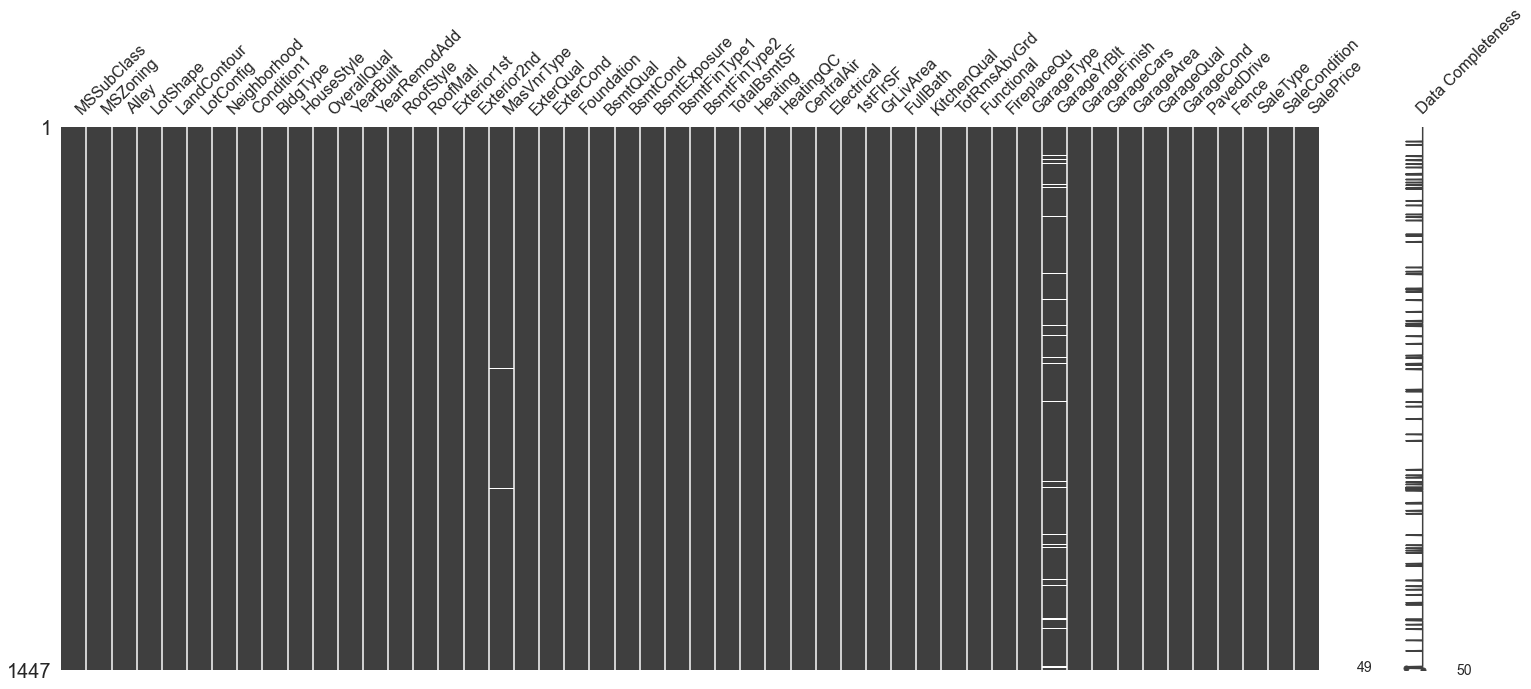

In [380]:
filtered_data = msno.nullity_filter(trainDf, filter='top', p=0.20)
msno.matrix(filtered_data, labels=True);

In [381]:
#missing data
total = trainDf.isnull().sum().sort_values(ascending=False)
percent = (trainDf.isnull().sum()/trainDf.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
GarageYrBlt,81,0.056
MasVnrType,8,0.006
Electrical,1,0.001
SalePrice,0,0.000
YearRemodAdd,0,0.000
BsmtQual,0,0.000
Foundation,0,0.000
ExterCond,0,0.000
ExterQual,0,0.000
Exterior2nd,0,0.000


In [382]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 50 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1447 non-null   object
 1   MSZoning       1447 non-null   object
 2   Alley          1447 non-null   object
 3   LotShape       1447 non-null   object
 4   LandContour    1447 non-null   object
 5   LotConfig      1447 non-null   object
 6   Neighborhood   1447 non-null   object
 7   Condition1     1447 non-null   object
 8   BldgType       1447 non-null   object
 9   HouseStyle     1447 non-null   object
 10  OverallQual    1447 non-null   int64 
 11  YearBuilt      1447 non-null   object
 12  YearRemodAdd   1447 non-null   object
 13  RoofStyle      1447 non-null   object
 14  RoofMatl       1447 non-null   object
 15  Exterior1st    1447 non-null   object
 16  Exterior2nd    1447 non-null   object
 17  MasVnrType     1439 non-null   object
 18  ExterQual      1447 non-null

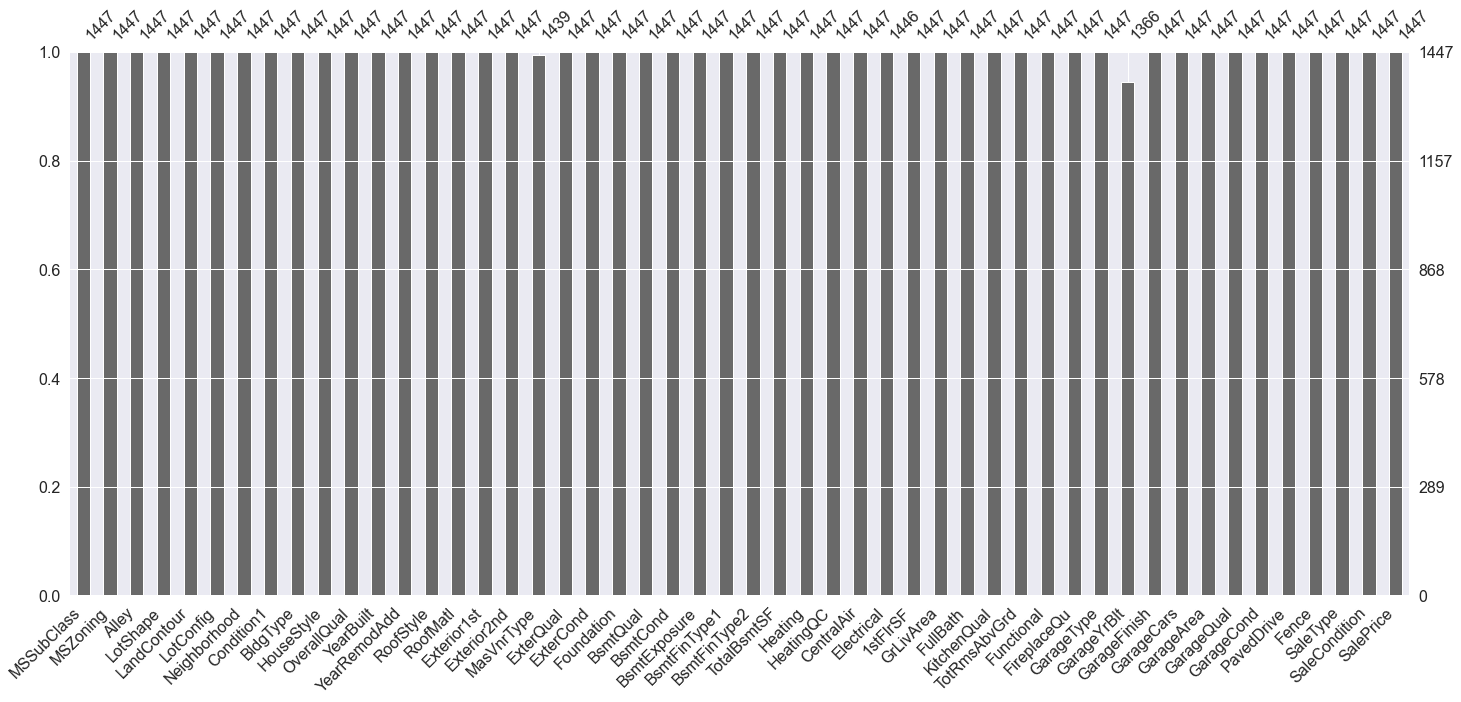

In [344]:
msno.bar(trainDf, labels=True);

In [386]:
#trainDf.reset_index(level='Id')
#trainDf.rename_axis('Id').reset_index()
trainDf.to_csv('House_Price_Final_Dataset.csv', index=True, index_label='Id')

In [385]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 50 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1447 non-null   object
 1   MSZoning       1447 non-null   object
 2   Alley          1447 non-null   object
 3   LotShape       1447 non-null   object
 4   LandContour    1447 non-null   object
 5   LotConfig      1447 non-null   object
 6   Neighborhood   1447 non-null   object
 7   Condition1     1447 non-null   object
 8   BldgType       1447 non-null   object
 9   HouseStyle     1447 non-null   object
 10  OverallQual    1447 non-null   int64 
 11  YearBuilt      1447 non-null   object
 12  YearRemodAdd   1447 non-null   object
 13  RoofStyle      1447 non-null   object
 14  RoofMatl       1447 non-null   object
 15  Exterior1st    1447 non-null   object
 16  Exterior2nd    1447 non-null   object
 17  MasVnrType     1439 non-null   object
 18  ExterQual      1447 non-null

In [387]:
cat_feat = trainDf.select_dtypes(include=['category', 'object']).columns
cat_feat

Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [ ]:
def root_mean_squared_log_error(y_valid, y_preds):
    """Calculate root mean squared error of log(y_true) and log(y_pred)"""
    if len(y_preds)!=len(y_valid): return 'error_mismatch'
    y_preds_new = [math.log(x) for x in y_preds]
    y_valid_new = [math.log(x) for x in y_valid]
    return mean_squared_error(y_valid_new, y_preds_new, squared=False)